In [1]:
import xarray
import pathlib
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [2]:
economic_path = pathlib.Path('../../workflow/output/aachen-union-z19/economic')

In [3]:
ds = xarray.open_dataset(str(economic_path / 'lcoe.nc'))

In [4]:
ds.info()

xarray.Dataset {
dimensions:
	superst_id = 323 ;
	filtered_id = 33803 ;
	location = 37747 ;
	time = 17520 ;

variables:
	int64 superst_id(superst_id) ;
	object superst_wkt_latlon(superst_id) ;
	object superst_wkt_xy(superst_id) ;
	int64 superst_seg_class(superst_id) ;
	float64 superst_img_center_lat(superst_id) ;
	float64 superst_img_center_lon(superst_id) ;
	float64 superst_area(superst_id) ;
	object filtered_wkt_latlon(filtered_id) ;
		filtered_wkt_latlon:type = str ;
		filtered_wkt_latlon:str_format = wkt ;
	object filtered_wkt_xy(filtered_id) ;
		filtered_wkt_xy:type = str ;
		filtered_wkt_xy:str_format = wkt ;
	float64 filtered_img_center_lat(filtered_id) ;
		filtered_img_center_lat:type = float ;
	float64 filtered_img_center_lon(filtered_id) ;
		filtered_img_center_lon:type = float ;
	float64 filtered_azimuth(filtered_id) ;
		filtered_azimuth:type = float ;
	float64 filtered_tilt(filtered_id) ;
		filtered_tilt:type = float ;
	float64 filtered_flat(filtered_id) ;
		filtered_flat:t

In [5]:
ds = ds[['section_azimuth', 'section_tilt', 'section_area', 'section_capacity',
                'section_panel_area', 'section_yearly_system_generation',
                'section_lcoe', 'section_yearly_capacity_factor',
                 'section_modules_cost',
                'panel_yearly_system_generation', 'panel_capacity']]

In [6]:
print(f'Mean LCOE: {ds.section_lcoe.mean().item()} €/MWh.')
print(f'Total panel capacity: {ds.section_capacity.sum().item() / 1000 / 1000} MW.')
print(f'Total yearly generation below threshold: {ds.section_yearly_system_generation.sum().item() / 1000 / 1000 / 1000} GWh.')

Mean LCOE: 72.64883102006861 €/MWh.
Total panel capacity: 806.6218299999999 MW.
Total yearly generation below threshold: 746.531553273414 GWh.


Text(0.5, 0, 'Rooftop sections')

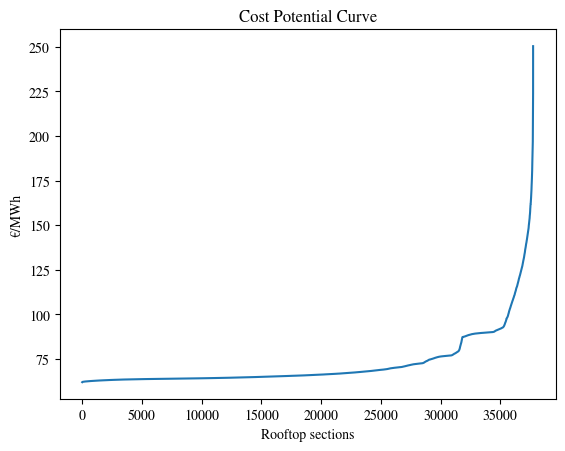

In [7]:
plt.title('Cost Potential Curve')
plt.plot(ds.section_lcoe.sortby(ds.section_lcoe))
plt.ylabel('€/MWh')
plt.xlabel('Rooftop sections')

Mean LCOE below threshold: 69.35599754409036 €/MWh.
Total panel capacity: 799.7794200000001 MW.
Total yearly generation below threshold: 742.9934284163431 GWh.


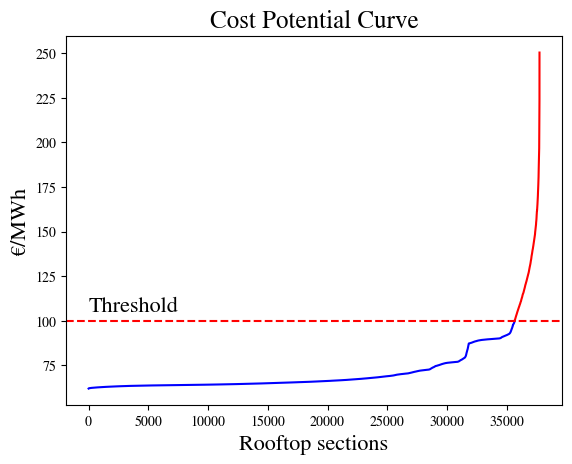

In [13]:
# Define a threshold €/MWh and calculate those below it
threshold_emwh = 100

below = ds.where(ds.section_lcoe < threshold_emwh, drop=True)
above = ds.where(ds.section_lcoe >= threshold_emwh, drop=True)

below_x = range(len(below.location))
above_x = range(len(below.location), len(ds.location))

plt.title('Cost Potential Curve', fontsize=18)
plt.plot(below_x, below.section_lcoe.sortby(ds.section_lcoe), color='blue')
plt.plot(above_x, above.section_lcoe.sortby(ds.section_lcoe), color='red')
plt.axhline(y=threshold_emwh, color='r', linestyle='--')
plt.text(30,105,'Threshold', fontsize=16)

plt.ylabel('€/MWh', fontsize=16)
plt.xlabel('Rooftop sections', fontsize=16)

print(f'Mean LCOE below threshold: {below.section_lcoe.mean().item()} €/MWh.')
print(f'Total panel capacity: {below.section_capacity.sum().item() / 1000 / 1000} MW.')
print(f'Total yearly generation below threshold: {below.section_yearly_system_generation.sum().item() / 1000 / 1000 / 1000} GWh.')

In [9]:
total_budget = 1000000 # €
print(f'Total initial investment: {total_budget}€')

current_budget = 0
locs = []
for cost in ds.sortby(ds.section_lcoe, ascending=True).section_modules_cost:
    if (current_budget + cost) <= total_budget:
        print(f'Can invest {cost.item()}€ in section {cost.location.item()}')
        current_budget += cost
        locs.append(cost.location)

possible_ds = ds.isel(location=locs)

print(f'Mean LCOE investing: {possible_ds.section_lcoe.mean().item()} €/MWh.')
print(f'Total panel capacity: {possible_ds.section_capacity.sum().item() / 1000 / 1000} MW.')
print(f'Total yearly generation: {possible_ds.section_yearly_system_generation.sum().item() / 1000 / 1000 / 1000} GWh.')

Total initial investment: 1000000€
Can invest 32900.0€ in section 35992
Can invest 337400.0€ in section 34873
Can invest 113050.0€ in section 33461
Can invest 437500.0€ in section 35183
Can invest 78050.0€ in section 33463
Can invest 1050.0€ in section 36015
Mean LCOE investing: 63.43224193662986 €/MWh.
Total panel capacity: 1.0570899999999999 MW.
Total yearly generation: 1.0078798167244591 GWh.


# Filtering sections

In [10]:
print(f'Original length: {len(ds.location)}')

filter_ds = ds

print('Filtering azimuth and tilt...')

filter_ds = filter_ds.where(filter_ds.section_azimuth >= 90, drop=True)
filter_ds = filter_ds.where(filter_ds.section_azimuth <= 270, drop=True)
print(f'Length after filtering azimuth: {len(filter_ds.location)}')

mean_area = ds.section_area.mean().item()
std_area = ds.section_area.std().item()
filter_ds = filter_ds.where(filter_ds.section_area < (mean_area + std_area * 3), drop=True)

print(f'Length after filtering std area: {len(filter_ds.location)}')

Original length: 37747
Filtering azimuth and tilt...
Length after filtering azimuth: 35401
Length after filtering std area: 34804


Mean LCOE after filtering: 69.31552822066952 €/MWh.
Total panel capacity: 577.95702 MW.
Total yearly generation after filtering: 536.9597607526958 GWh.


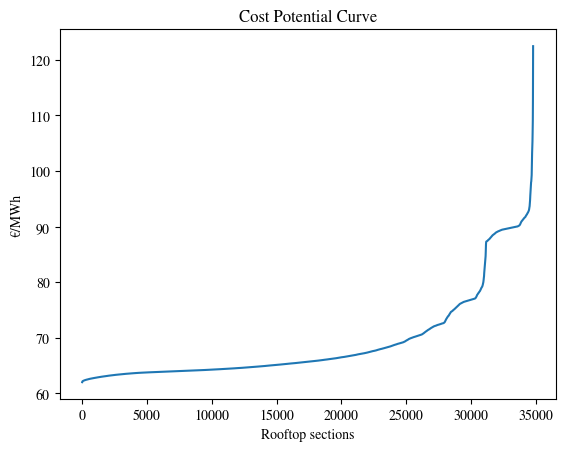

In [11]:
plt.title('Cost Potential Curve')
plt.plot(filter_ds.section_lcoe.sortby(filter_ds.section_lcoe))
plt.ylabel('€/MWh')
plt.xlabel('Rooftop sections')


print(f'Mean LCOE after filtering: {filter_ds.section_lcoe.mean().item()} €/MWh.')
print(f'Total panel capacity: {filter_ds.section_capacity.sum().item() / 1000 / 1000} MW.')
print(f'Total yearly generation after filtering: {filter_ds.section_yearly_system_generation.sum().item() / 1000 / 1000 / 1000} GWh.')